### PREPROCESS

In [1]:
from preprocessing.preprocess_datasets import *
import pandas as pd
import numpy as np

In [8]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


Correlations for residuals of lgb:
Tg, Density : -0.42 (only 25 rows more or less)
Tc, Rg : 0.93 (500 rows)

In [10]:
print(train_df.shape)
train_df.isna().sum()

(7973, 7)


id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

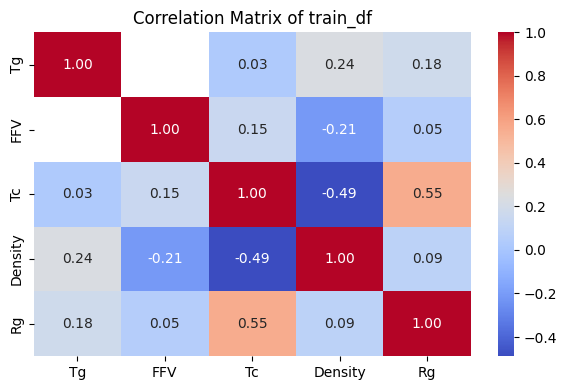

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

corr = train_df.iloc[:, 2:].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of train_df')
plt.tight_layout()
plt.show()

In [ ]:
train_aug_df = build_augmented_train(
    "data/train.csv",
    [f"data/train_supplement/dataset{i}.csv" for i in range(1, 5)]
)
train_aug_df.to_parquet('data/train_augmented/train_augmented.parquet', index=False)

↻ Canonicalising:   0%|          | 0/7973 [00:00<?, ?it/s]

↻ Canonicalising:   0%|          | 0/874 [00:00<?, ?it/s]

↻ Canonicalising:   0%|          | 0/7208 [00:00<?, ?it/s]

↻ Canonicalising:   0%|          | 0/46 [00:00<?, ?it/s]

↻ Canonicalising:   0%|          | 0/862 [00:00<?, ?it/s]

Run generation of embeddings using two fined tuned models

In [29]:
'''
!python preprocessing/generate_embeddings.py \
      --input  data/train_augmented/train_augmented.parquet \
      --output data/train_embeds \
      --device cuda 
'''

'\n!python preprocessing/generate_embeddings.py       --input  data/train_augmented/train_augmented.parquet       --output data/train_embeds       --device cuda \n'

In [1]:
from utils.utils import build_feature_matrix
from preprocessing.rdkit_morgan import add_all_rdkit_descriptors, add_morgan_fingerprints
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
import hdbscan

df_full = build_feature_matrix(
    augmented_path   = "data/train_augmented/train_augmented.parquet",
    embeds_meta_path = "data/train_embeds/train_embeds.parquet",
    embeds_npz_path  = "data/train_embeds/train_embeds.npz"
)

# load embeddings
vecs = np.load("data/train_embeds/train_embeds.npz")
cb = vecs["chemberta"].astype("float32")   # (N, 384)
mf = vecs["molformer"].astype("float32")   # (N, 768)

assert len(df_full) == cb.shape[0]

# --- 1. ChemBERTa clusters ---------------------------------
df_full["cb_k20"]   = KMeans(20, n_init=10, random_state=42).fit_predict(cb)
df_full["cb_hdb25"] = hdbscan.HDBSCAN(
        min_cluster_size=25, min_samples=25).fit_predict(cb)

# --- 2. MolFormer clusters ---------------------------------
df_full["mf_k20"]   = KMeans(20, n_init=10, random_state=42).fit_predict(mf)
df_full["mf_hdb25"] = hdbscan.HDBSCAN(
        min_cluster_size=25, min_samples=25).fit_predict(mf)


df_full = add_all_rdkit_descriptors(df_full)
df_full = add_morgan_fingerprints(df_full) 

df_full.to_parquet('data/train_ready/train_full.parquet', index=False)

c:\Users\nicco\OneDrive\Documents\projects\kaggle\neurips\utils\utils.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  emb_df[[f"cb_{i}" for i in range(cb.shape[1])]] = cb
c:\Users\nicco\OneDrive\Documents\projects\kaggle\neurips\utils\utils.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  emb_df[[f"cb_{i}" for i in range(cb.shape[1])]] = cb
c:\Users\nicco\OneDrive\Documents\projects\kaggle\neurips\utils\utils.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

RDKit descriptors (all):   0%|          | 0/8881 [00:00<?, ?it/s]

Morgan fold-256:   0%|          | 0/8881 [00:00<?, ?it/s]

In [7]:
from preprocessing.imputation import impute_with_miceforest, apply_imputation
from training.train import train_single_model_and_report, _get_feature_cols
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


TARGETS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

df_full = pd.read_parquet('data/train_ready/train_full.parquet')

X_train, X_test = train_test_split(df_full, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


# Apply imputation to test data using the trained kernel
#test_imputed = apply_imputation(X_test, imputation_kernel)

# 4. Train models and evaluate on train data
metrics_train, models, feat_cols = train_single_model_and_report(
    X_train,  # Use imputed training data
    X_test,
    target_cols=TARGETS,
    random_state=42
)

print("\nTest Set Evaluation:")
for target, model in models.items():
    # Get features and target from test data
    test_features = _get_feature_cols(X_test, TARGETS)
    test_target = X_test[target].dropna()
    print(f"test set after drop has {test_target.shape[0]} values for target {target}")
    test_X = X_test.loc[test_target.index, test_features]
    
    # Make predictions
    preds = model.predict(test_X)
    mae = mean_absolute_error(test_target, preds)
    print(f"── {target:<8} | Test MAE {mae:.4f}")

Train set: (7104, 1628), Test set: (1777, 1628)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188746
[LightGBM] [Info] Number of data points in the train set: 464, number of used features: 1484
[LightGBM] [Info] Start training from score 101.568993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [11]:
df_full.isna().sum()[2:7]

Tg         8324
FFV         989
Tc         8144
Density    8268
Rg         8267
dtype: int64